In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from airfoil_DDPM import Unet,airfoil_diffusion,airfoil_diffusion_multitask
from torch.utils.data import DataLoader,TensorDataset
from torch.utils.tensorboard import SummaryWriter
#from mlp_data import MyData
import pandas as pd
import csv
import numpy as np
import arifoil_DDPM_tools
import matplotlib.pyplot as plt
import subprocess
import os

def read_xfoil_polar_file(file_path):
    data = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        reading_data = False
        for line in lines:
            if "alpha    CL        CD       CDp       CM     Top_Xtr  Bot_Xtr" in line:
                reading_data = True
                continue
            if reading_data and not line.startswith('#') and line.strip():
                values = line.split()
                try:
                    data.append([float(values[0]), float(values[1]), float(values[2]), float(values[3]), float(values[4])])
                except ValueError:
                    pass
    return np.array(data)

def read_polar_files(file_path):
    values=read_xfoil_polar_file(file_path)
    results = {'cl': [], 'cd': [], 'cm': []}
    results['cl'].append(values[:,1])
    results['cd'].append(values[:,2])
    results['cm'].append(values[:,4])
    #os.remove(file_path)
    return results

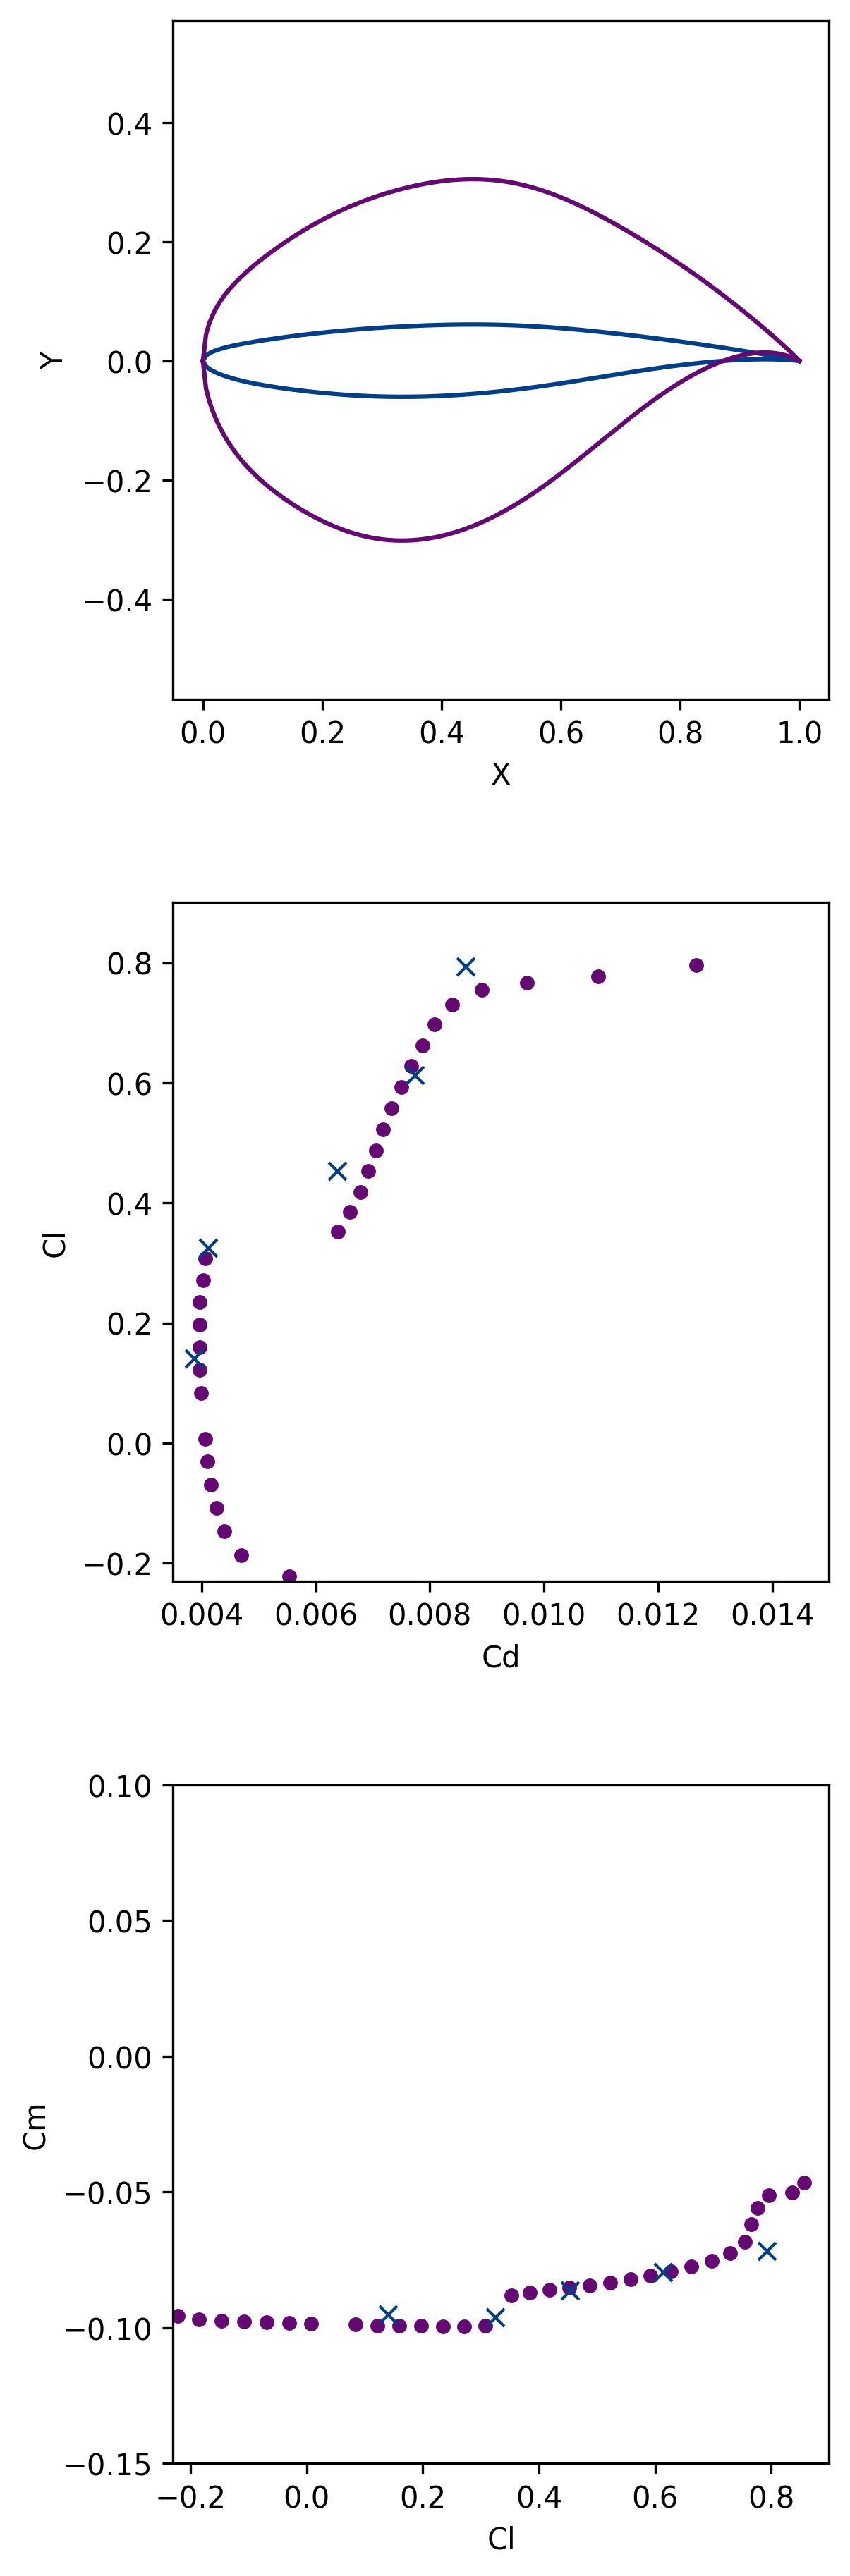

In [5]:
results=read_polar_files('D:/Xfoil/airfoil_polars.txt')#生成翼型的极曲线数据
context_1=np.array([[0.008496,0.1211,0.379]])#R,t_max,X_c
context_2=np.array([[0.1405,0.00386,-0.0952],[0.3253,0.00411,-0.0962],[0.4536,0.00637,-0.0863],[0.6133,0.00773,-0.0795],[0.7931,0.00862,-0.0717]])#sets of Cl，Cd，Cm
CST=np.array([ 0.1259,  0.0980,  0.1449,  0.1852,  0.0467,  0.3759,  0.0132,  0.2729,0.1390,  0.2112, -0.1293, -0.1686, -0.0763, -0.3083,  0.0120, -0.3169,-0.0270, -0.0781, -0.0154,  0.1055])#CST paras of airfoil
# 生成小图的数据
X = np.linspace(0, 1, 200)
Y_up, Y_down = arifoil_DDPM_tools.locate_plot(CST, X=X)
Y_up_scaled = [y * 5 for y in Y_up]
Y_down_scaled = [y * 5 for y in Y_down]
R,t,t_co,up_R=arifoil_DDPM_tools.CST_cal(CST)
# 创建大图和子图
plt.rcParams['figure.dpi'] = 300
#fig, axes = plt.subplots(1, 3, figsize=(26, 5))
fig, axes = plt.subplots(3, 1, figsize=(4, 15))
fig.subplots_adjust(hspace=0.3)
#fig.subplots_adjust(wspace=0.3)

# 绘制小图
axes[0].plot(X, Y_up, label='Airfoil', color=(0/255, 63/255, 136/255))
axes[0].plot(X, Y_down, label='Airfoil', color=(0/255, 63/255, 136/255))
axes[0].plot(X, Y_up_scaled, label='Scaled Airfoil', color=(102/255, 8/255, 116/255))
axes[0].plot(X, Y_down_scaled, label='Scaled Airfoil', color=(102/255, 8/255, 116/255))
axes[0].axis('equal')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
#axes[0].legend()
#axes[0].set_title(f"Target_R:{context_1[0][0]:.4f},   Target_thickness:{context_1[0][1]:.3f},   Target_thickness_coordinate:{context_1[0][2]:.3f}\nGenerate_R:{R:.4f}, Generate_thickness:{t:.3f}, Generate_thickness_coordinate:{t_co:.3f}")

# 绘制第二个子图（示例，可以根据实际需求修改）
axes[1].plot(results['cd'],results['cl'],'o',label='Generated',color=(102/255, 8/255, 116/255), markersize=4)
axes[1].plot(context_2[:,1],context_2[:,0],'x',label='Target',color=(0/255, 63/255, 136/255), markersize=6)
axes[1].set_xlim(0.0035, .015)
axes[1].set_ylim(-.23, 0.9)
axes[1].set_xlabel('Cd')
axes[1].set_ylabel('Cl')
#axes[1].legend()
#axes[1].set_title('Polar Curve')

# 绘制第三个子图（示例，可以根据实际需求修改）
axes[2].plot(results['cl'],results['cm'],'o',label='Generated',color=(102/255, 8/255, 116/255), markersize=4)
axes[2].plot(context_2[:,0],context_2[:,2],'x',label='Target',color=(0/255, 63/255, 136/255), markersize=6)
axes[2].set_xlabel('Cl')
axes[2].set_ylabel('Cm')
#axes[2].set_title('Pitching Moment Coefficient Curve')
axes[2].set_xlim(-.23, 0.9)
axes[2].set_ylim(-.15, .1)
plt.show()